In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# pprevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', 90)
warnings.simplefilter("ignore")

In [2]:
img_dir=r'./honey_bees'
csvpath=r'./bee_data.csv'
df=pd.read_csv(csvpath)
# drop columns that we will not be using
df=df.drop(['date', 'time', 'location', 'zip code', 'health', 'pollen_carrying', 'caste'], axis=1)
# rename the columns
df.columns= ['filepaths', 'labels']
# make the filepaths column contain the full path to the image
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(img_dir, x))
# lets check to see if there are any missing values in df
print (' The total number of missing values in df is ', df.isna().sum().sum())
print (' The dataframe initially has ', len(df), ' rows')

 The total number of missing values in df is  0
 The dataframe initially has  5172  rows


In [3]:
new_model = tf.keras.models.load_model('bees_95.55.h5')

In [4]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 70, 70, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 70, 70, 3)    0           ['normalization[0][0]']          
                                                                                              

                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 37, 37, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 18, 18, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 18, 18, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_a

 block2c_activation (Activation  (None, 18, 18, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_s

                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 9, 9, 288)    0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 9, 9, 48)     13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_p

                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 5, 5, 288)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 5, 5, 96)     27648       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 5, 5, 96)    384         ['block4a_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4c_drop (Dropout)         (None, 5, 5, 96)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 5, 5, 96)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 5, 5, 576)    55296       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 5, 5, 576)   2304        ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 5, 5, 576)    55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 5, 5, 576)   2304        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 5, 5, 576)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 5, 5, 576)   14400       ['block5a_expand_activation[0][0]
 D)       

 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 5, 5, 816)   3264        ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 5, 5, 816)   0           ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 816)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5e_activation (Activation  (None, 5, 5, 816)   0           ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 34)     27778       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 3, 3, 1392)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 3, 3, 232)    322944      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_p

 block6d_se_excite (Multiply)   (None, 3, 3, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 3, 3, 232)    322944      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 3, 3, 232)   928         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 3, 3, 232)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_a

 block6f_project_bn (BatchNorma  (None, 3, 3, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 3, 3, 232)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 3, 3, 232)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 3, 3, 1392)   322944      ['block6f_add[0][0]']            
                                                                                                  
 block7a_e

 top_bn (BatchNormalization)    (None, 3, 3, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 3, 3, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 max_pool (GlobalMaxPooling2D)  (None, 1536)         0           ['top_activation[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 1536)        6144        ['max_pool[0][0]']               
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 1024)         1573888     ['batch_normalization[0][0]']    
          

In [5]:
test_gen = ImageDataGenerator()
img_size=(70,70)
batch_size=40
length=len(df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
testdata = test_gen.flow_from_dataframe(df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 5172 validated image filenames belonging to 7 classes.


In [6]:
classes=list(testdata.class_indices.keys())
class_indices=list(testdata.class_indices.values())
class_count=len(classes)
labels=testdata.labels

In [7]:
class_count

7

In [8]:
y_pred= []
y_true=testdata.labels
errors=0
preds = new_model.predict(testdata, steps=test_steps, verbose=1)

2022-09-15 17:21:56.847973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


431/431 [==============================] - 21s 46ms/step


there were 245 in 5172 tests for an accuracy of  95.26


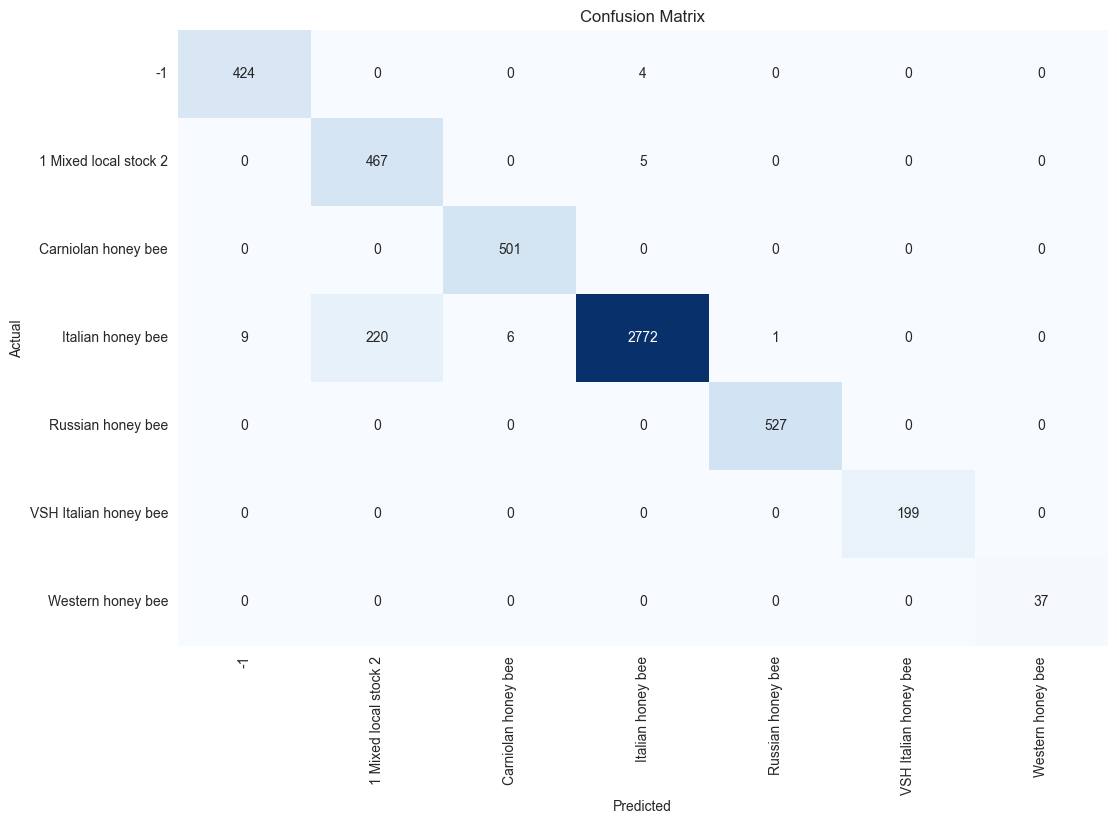

In [9]:
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=testdata.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()